In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import MobileNetV2,Xception,EfficientNetB7,InceptionResNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input,LSTM, ConvLSTM2D, MaxPooling3D, TimeDistributed, Dense, Flatten, Dropout, Bidirectional, MaxPooling2D, InputLayer, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from IPython.display import clear_output,Video

import os
import json
import cv2

#constants
IMG_SIZE = 128
FRAME_COUNT = 15

## Loading Data 

In [3]:
scvd_train_dir = './SCVD/SCVD_converted_sec_split/Train'
scvd_test_dir = './SCVD/SCVD_converted_sec_split/Test'
scvd_classes = ['Normal', 'Violence','Weaponized']

## Read Frames 

In [4]:
def load_video(path, nframes=FRAME_COUNT, size=(IMG_SIZE, IMG_SIZE)):
    frames = []
    cap = cv2.VideoCapture(path)

    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # Get the total number of frames in the video
    skip_frames = max(1, (total_frames // nframes) -1)  # Ensure at least 1 frame is skipped

    for _ in range(nframes):
        ret, frame = cap.read()  # Read the current frame
        if not ret:
            break

        # Process the current frame (resize, convert, normalize)
        frame = cv2.resize(frame, size)
        frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
        frame = frame / 255.0
        frames.append(frame)

        # Skip the specified number of frames
        for _ in range(skip_frames):
            cap.grab()  # Advance to the next frame without reading it

    cap.release() 
    return frames


def extract_frames(main_directory):
    features = []
    labels = []
    for c in scvd_classes:
        class_dir = os.path.join(main_directory,c)
        for i,video in enumerate(os.listdir(class_dir)): 
            if i < 650:
                if video.endswith(('.mp4', '.avi', '.mov')): 
                    video_path = os.path.join(class_dir, video)

                    # Load and process the video
                    frames = load_video(video_path)

                    if len(frames) == FRAME_COUNT:
                        features.append(frames)
                        labels.append(c)
    return np.asarray(features),np.array(labels)

In [5]:
normal = load_video('./SCVD/SCVD_converted_sec_split/Train/Normal/Normal001.avi')
violence = load_video('./SCVD/SCVD_converted_sec_split/Train/Violence/Violence001.avi')
weaponized = load_video('./SCVD/SCVD_converted_sec_split/Train/Weaponized/Weaponized001.avi')

In [6]:
normal[0].shape,violence[0].shape,weaponized[0].shape

((128, 128, 3), (128, 128, 3), (128, 128, 3))

***Original frame size 720x1280 we will resize it to 128x128***

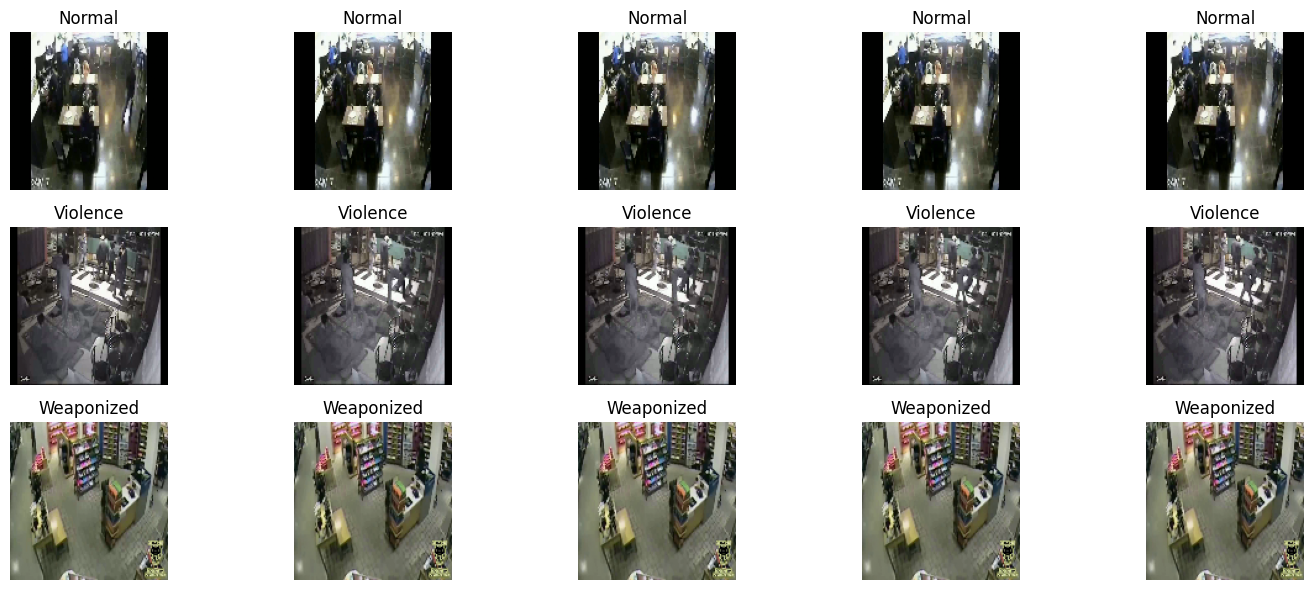

In [7]:
plt.figure(figsize=(15,6))

# Normal frames
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(normal[-i])
    plt.title("Normal")
    plt.axis('off')

# Violence frames
for i in range(5):
    plt.subplot(3, 5, i + 6)
    plt.imshow(violence[-i])
    plt.title("Violence")
    plt.axis('off')
    
# Weaponized frames
for i in range(5):
    plt.subplot(3, 5, i + 11)
    plt.imshow(weaponized[-i])
    plt.title("Weaponized")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
X_train,y_train = extract_frames(scvd_train_dir)
X_test,y_test = extract_frames(scvd_test_dir)

In [9]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((1949, 15, 128, 128, 3), (1949,), (477, 15, 128, 128, 3), (477,))

In [10]:
np.unique(y_train)

array(['Normal', 'Violence', 'Weaponized'], dtype='<U10')

##  Compining weaponized,violence into one label "Violence" 

In [11]:
y_train = np.where(y_train == 'Weaponized','Violence',y_train)

y_test = np.where(y_test == 'Weaponized','Violence',y_test)

In [12]:
np.unique(y_train)

array(['Normal', 'Violence'], dtype='<U10')

In [13]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

#  Model

In [14]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(TimeDistributed(base_model, input_shape=(15, 128, 128, 3)))
model.add(TimeDistributed(GlobalAveragePooling2D())) 
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(BatchNormalization()))

model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ ?                      │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
  './working/cctvmodel.keras',  
    monitor='val_loss',
    save_best_only=True,  
    mode='min',  
)
history = model.fit(
    x=X_train,
    y= y_train,
    validation_split=0.2,
    callbacks=[early_stopping,checkpoint],
    epochs= 30,
)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.6516 - loss: 0.6985 - val_accuracy: 0.8308 - val_loss: 0.5461
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.9149 - loss: 0.2069 - val_accuracy: 0.9538 - val_loss: 0.3166
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9794 - loss: 0.0714 - val_accuracy: 0.9590 - val_loss: 0.2194
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9784 - loss: 0.0686 - val_accuracy: 0.9769 - val_loss: 0.1256
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9864 - loss: 0.0490 - val_accuracy: 0.9436 - val_loss: 0.1480
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.9919 - loss: 0.0335 - val_accuracy: 0.9615 - val_loss: 0.1024
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.9881 - loss: 0.0210 - val_accuracy: 0.9256 - val_loss: 0.2252
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.9975 - loss: 0.0139 - val_accuracy: 0.9564 - v

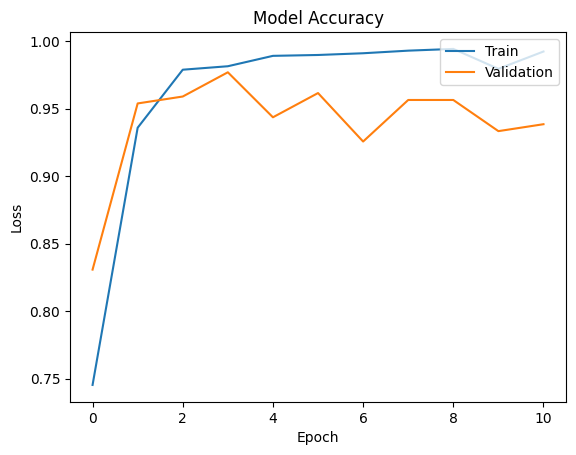

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

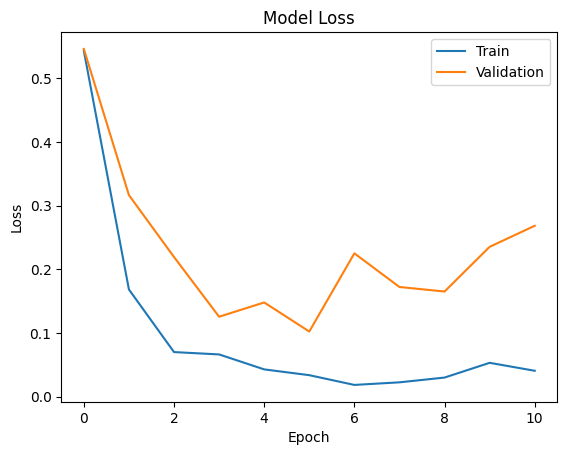

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [19]:
model.evaluate(X_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9976 - loss: 0.0091


[0.025437820702791214, 0.9916142821311951]

15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       169
           1       1.00      0.99      0.99       308

    accuracy                           0.99       477
   macro avg       0.99      0.99      0.99       477
weighted avg       0.99      0.99      0.99       477



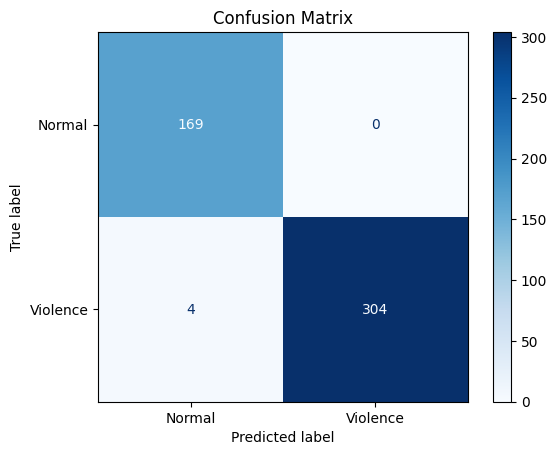

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Violence'])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [21]:
model.save(filepath='./Models/violence_detection.h5')

In [ ]:
def predict_video_class(video_path):
    # Load and preprocess the video
    frames = load_video(video_path)
    
    if len(frames) != FRAME_COUNT:
        print("Insufficient frames, cannot make prediction.")
        return None
    
    # Convert frames to numpy array and reshape for model input
    input_data = np.expand_dims(np.array(frames), axis=0)  # Shape (1, 15, 128, 128, 3)

    # Run inference
    prediction = model.predict(input_data)
    
    # Interpret the result
    if prediction >= 0.5:
        return "Violence"
    else:
        return "Normal"

# Example usage:
# video_path = 'SCVD/SCVD_converted/Test/Violence/t_v002_converted.avi'
video_path = 'SCVD/SCVD_converted/Test/Normal/t_n002_converted.avi'
# video_path = 'SCVD/SCVD_converted/Test/Weaponized/t_w002_converted.avi'

result = predict_video_class(video_path)
print("Prediction:", result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction: Normal
